# Importing libraries

In [0]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
import torch.nn.functional as F
import os.path

resume_weights = "/content/drive/My Drive/22-2/checkpoint4.pth.tar"
cuda = torch.cuda.is_available()

In [0]:
transform = transforms.Compose([transforms.ToTensor(), 
                                  transforms.Normalize((0.5,), (0.5,)) ])

# Preparing data

In [0]:
torch.backends.cudnn.deterministic = True
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

In [0]:
trainset = datasets.MNIST('/data', download=True, train=True, transform=transform)
testset = datasets.MNIST('/data', download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [21]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)
print(labels)

torch.Size([64, 1, 28, 28])
torch.Size([64])
tensor([9, 3, 0, 1, 2, 4, 6, 8, 1, 1, 2, 3, 0, 7, 0, 0, 1, 3, 9, 4, 1, 1, 2, 9,
        0, 0, 1, 4, 6, 2, 1, 3, 0, 8, 8, 1, 9, 5, 9, 0, 2, 8, 7, 2, 9, 5, 7, 1,
        4, 1, 8, 6, 1, 8, 7, 0, 1, 3, 4, 3, 2, 7, 7, 7])


In [22]:
print(images[0].shape)

torch.Size([1, 28, 28])


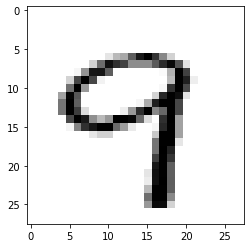

In [23]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

In [0]:
best_accuracy = torch.FloatTensor([0])
start_epoch = 0

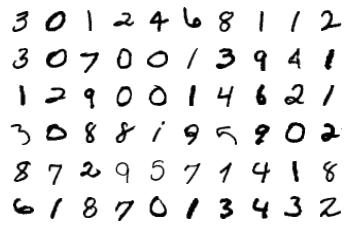

In [25]:
num_of_images = 60
for index in range(1, num_of_images+1):
  plt.subplot(6, 10, index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Defining the Network

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1,30,5)
    self.conv2 = nn.Conv2d(30,15,3)
    self.pool = nn.MaxPool2d(2,2)
    self.drop = nn.Dropout(0.2)
    self.fc1 = nn.Linear(5*5*15,128)
    self.fc2 = nn.Linear(128,50)
    self.fc3 = nn.Linear(50,10)
  
  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.drop(x)
    x = x.view(-1,5*5*15)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    x = F.log_softmax(x,dim=1)
    return x

net = Net()

In [0]:
criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()
optimizer = optim.Adam(net.parameters())

# Saving model

In [0]:
def save_checkpoint(state, is_best, filename = "/content/drive/My Drive/22-2/checkpoint4.pth.tar"):
    if is_best:
        print ("=> Saving a new best")
        torch.save(state, filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")

In [29]:
if os.path.isfile(resume_weights):
    print("=> loading checkpoint '{}' ...".format(resume_weights))
    #if cuda:
    checkpoint = torch.load(resume_weights)
    #else:
     #   checkpoint = torch.load(resume_weights,
      #                          map_location=lambda storage,
       #                         loc: storage)
    start_epoch = checkpoint['epoch']
    best_accuracy = checkpoint['best_accuracy']
    print('=> loaded checkpoint {} (trained for {} epochs) with {:.4}% test accuracy'.format(resume_weights,
        checkpoint['epoch'],100 * best_accuracy.numpy()[0]))
    net.load_state_dict(checkpoint['state_dict'])
else:print("no") 

no


# Forward loop

In [0]:
def eval():
  net.eval()
  correct = 0
  total = 0
  with torch.no_grad():
   for data in testloader:
     images, labels = data
     outputs = net(images)
     _, predicted = torch.max(outputs,1)
     total += labels.size(0)
     correct  += (predicted == labels).sum().item()

  acc = correct/total
#print('Accuracy of the network over 10000 test images: %d %%' %(100  * correct/total))
  return acc

In [31]:
for epochs in range(1,3):

  running_loss = 0.0
  correct= 0
  total = 0

  for i, data in enumerate(trainloader,0):
      inputs, labels = data
      
      optimizer.zero_grad()
      outputs = net(inputs)
      loss = criterion(outputs,labels)
      loss.backward()
      optimizer.step()

      _, predicted = torch.max(outputs.data,1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      

      running_loss += loss.item()
      if i % 100 == 99:
            print('[%d, %5d] loss : %.3f acc: %.3f %%' % (epochs, i+1, running_loss/100, correct/total *100))
            running_loss = 0.0
            correct = 0
            total = 0
  acc1 = eval()
  print ('epoch: %d acc_test: %.3f %%' % (epochs, acc1*100))
  acc1 = torch.FloatTensor([acc1])
  is_best = bool(acc1.numpy() > best_accuracy.numpy())
  best_accuracy = torch.FloatTensor(max(acc1.numpy(), best_accuracy.numpy()))
  save_checkpoint({
      'epoch' : start_epoch + epochs,
      'state_dict' : net.state_dict(),
      'best_accuracy' : best_accuracy
      }, is_best)
  
print('Finished training')

[1,   100] loss : 0.961 acc: 71.297 %
[1,   200] loss : 0.273 acc: 92.141 %
[1,   300] loss : 0.184 acc: 94.422 %
[1,   400] loss : 0.151 acc: 95.234 %
[1,   500] loss : 0.140 acc: 95.812 %
[1,   600] loss : 0.125 acc: 96.047 %
[1,   700] loss : 0.104 acc: 96.656 %
[1,   800] loss : 0.105 acc: 96.750 %
[1,   900] loss : 0.105 acc: 96.750 %
epoch: 1 acc_test: 97.650 %
=> Saving a new best
[2,   100] loss : 0.076 acc: 97.719 %
[2,   200] loss : 0.063 acc: 98.125 %
[2,   300] loss : 0.058 acc: 98.219 %
[2,   400] loss : 0.057 acc: 98.094 %
[2,   500] loss : 0.057 acc: 98.047 %
[2,   600] loss : 0.053 acc: 98.391 %
[2,   700] loss : 0.048 acc: 98.594 %
[2,   800] loss : 0.058 acc: 98.203 %
[2,   900] loss : 0.045 acc: 98.719 %
epoch: 2 acc_test: 98.460 %
=> Saving a new best
Finished training
